# Machine Learning, Excercise 3

* Attila Lazar 0026842
* Bogdan 

In [1]:
import os
os.getcwd()
import matplotlib.pyplot as plt
os.chdir('/home/lazafi/labor/ml-2019/male2019/3/src/fruits')
os.getcwd()

import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
from PIL import Image
from glob import glob
import csv
import seaborn as sn
import pandas as pd

#from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

from helper import *



## Feature Variables

### Pixel Data

Images are read as 3-tupples of color values raging from 0 to 255. We use cv2 library for reading images and to convert them in rgb arrays.

The reading of the Images is hidden in the Class FIDS30DataSet, we only pass the absolute root directory. For demonstration purposes we can also limit the number of classes and number of images per class.

In [2]:
# read is limited to 2 files from 2 subdirecories
fruit2data = FIDS30DataSet("/home/lazafi/labor/ml-2019/male2019/3/data/FIDS30", limit=2)


 category strawberries 2
 category apples 2


### Histogram

From the pixel data we extracted color histograms. For the color images we count the occurances for each 256 colors in each of the 3 channels seperatelly and concat them to a long histogram of 768 colors. We also provide the option to reduce the histogram to the given amount of bins.


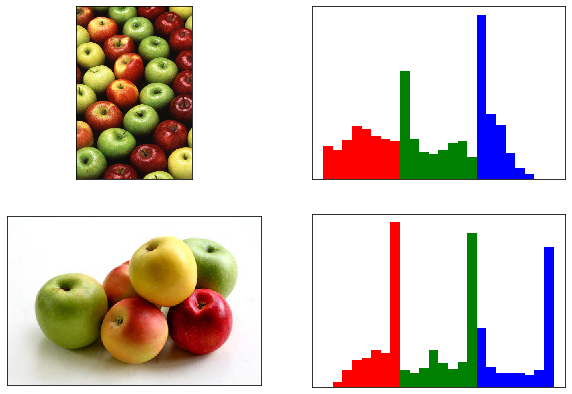

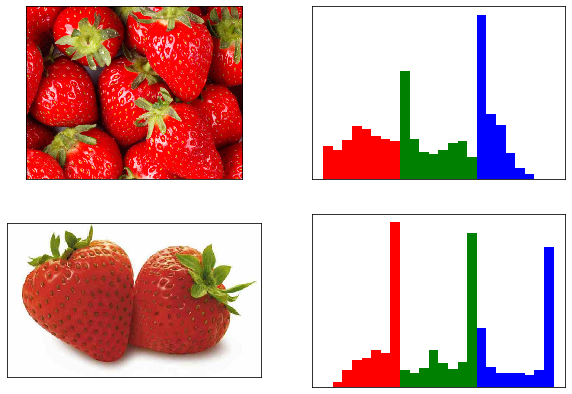

In [3]:
# we only use 10 bins per color channel
fruit2data.resetFeatures()
fruit2data.addFeatures(Histogram(8, debug=True))


### Visual Bag of Words

We use cv2 ORB implementation to describe features of images. First image Descriptor are extracted from all images. to reduce the amount of possible descriptors these are grouped using KMeans clustering (sklearn MiniBatchKMeans to save memory). These clustered descriptors are then counted for each image and a Histogram of the frequencies of these descriptors is used to train our 3 classifiers. 

We capsuled the code in class which we can pass to the dataset class to extract features. The parameter (10) is the amount to which the descriptors are reduced in the clustering process (number of clusters). 

In [4]:
#fruit2data.resetFeatures()
#fruit2data.addFeatures(BOV(10, debug = False))

## Classifiers

We used following classifiers from the sklearn library:

* Support Vector Machine Classifier
* knn Classifier
* Multi Layered Perceptron

From these "classic" classification methods we expect to achive our baseline performace. Then we will try to surpass this witch an deep convolutional neural network classifier setup. 


## Evaluation

For each experiment we divided our dataset in 67% training and 33% test images. For training we used the training set.

After training the model we used it on the test images to predict their class and computed the *confusion matrix* to visually inspect the accuracy of the classification. Additionaly we also use macro-averaged precission to compare between classifiers.

The code for evaluation is enclosed in the Experiment class method evaluate(). It can display confusion-matrix and print a detailed report about per class and overall accuracy. 

## FIDS30 Fruits Dataset

We used the FIDS30 dataset provided by the lecture. It consists of 30 directories containing ap. 30 images of one fruit.


### Historgam features


As a first experiment we extract Histogram Data from the Images and train different classifiers on this data to predict the kind of the fruit. 

In [5]:
# prepare the fids30 dataset with histogram features
fids30_data = FIDS30DataSet("/home/lazafi/labor/ml-2019/male2019/3/data/FIDS30")
fids30_data.addFeatures(Histogram(8))
print(fids30_data.count)

 category strawberries 46
 category apples 38
 category raspberries 39
 category mangos 34
 category avocados 26
 category coconuts 26
 category apricots 30
 category grapefruits 31
 category watermelons 31
 category plums 31
 category peaches 27
 category grapes 38
 category kiwifruit 36
 category lemons 29
 category passionfruit 22
 category blackberries 37
 category cherries 33
 category figs 26
 category bananas 42
 category acerolas 24
 category guava 33
 category olives 23
 category blueberries 32
 category cantaloupes 31
 category oranges 35
 category limes 29
 category tomatoes 46
 category pears 32
 category pineapples 34
 category pomegranates 30
971


In [6]:
print(fids30_data.labels)

['strawberries', 'apples', 'raspberries', 'mangos', 'avocados', 'coconuts', 'apricots', 'grapefruits', 'watermelons', 'plums', 'peaches', 'grapes', 'kiwifruit', 'lemons', 'passionfruit', 'blackberries', 'cherries', 'figs', 'bananas', 'acerolas', 'guava', 'olives', 'blueberries', 'cantaloupes', 'oranges', 'limes', 'tomatoes', 'pears', 'pineapples', 'pomegranates']


### Support Vector Machines Classifier

The SVM Classifier gave us the poorest results. For most of the test images the model failed to predict the correct class, most of images got classified as pommegranates and cheries. 

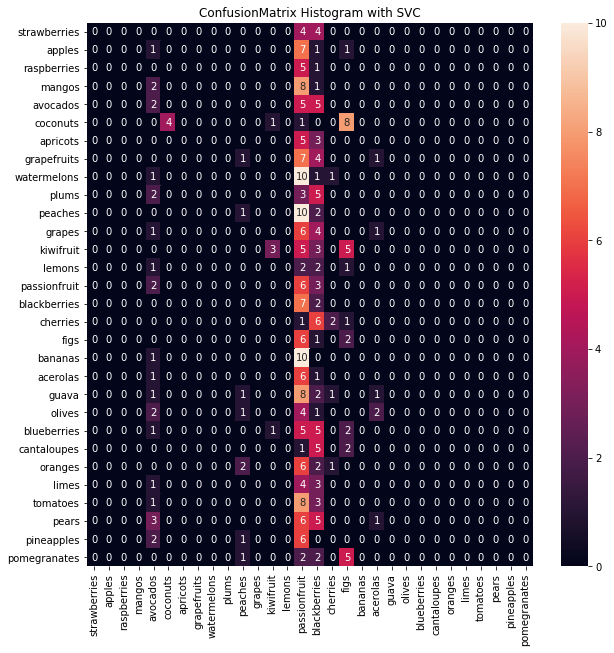

In [7]:
# svc

exp1 = Experiment(fids30_data, svm.SVC(gamma='auto'), "Histogram with SVC")
exp1.train()
exp1.evaluate(figure=True)


### k Nearest Neighbors classifier

We got better result using knn Classifier. Fruits with simular colors are most commonly missclassified: apples and cherries, watermelons and passionfruits. Some missclassifications are not as obvious like coconuts and oranges missclassified as avocados.

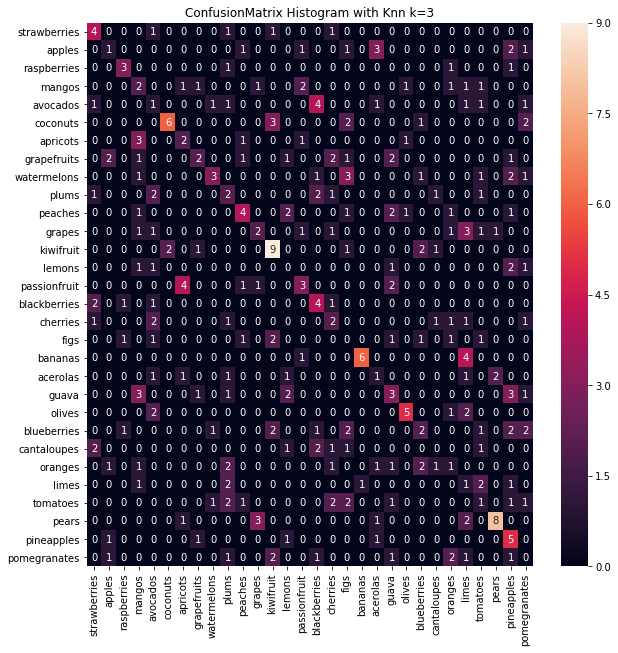

classifier KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='distance'):
              precision    recall  f1-score   support

           0       0.36      0.50      0.42         8
           1       0.17      0.10      0.12        10
           2       0.50      0.50      0.50         6
           3       0.13      0.18      0.15        11
           4       0.08      0.08      0.08        12
           5       0.75      0.43      0.55        14
           6       0.22      0.25      0.24         8
           7       0.33      0.15      0.21        13
           8       0.50      0.23      0.32        13
           9       0.13      0.20      0.16        10
          10       0.40      0.31      0.35        13
          11       0.29      0.17      0.21        12
          12       0.47      0.56      0.51        16
          13       0.00      0.00      0.00

In [8]:
# knn
exp1 = Experiment(fids30_data, KNeighborsClassifier(n_neighbors=3, weights = 'distance'),  "Histogram with Knn k=3")
exp1.train()
exp1.evaluate(figure=True, text=True)



#### diferent values for k

We tried to tune the performace with higher values for k. Different values for k only affect the precission marginaly, so we choose k=3 for better computability.

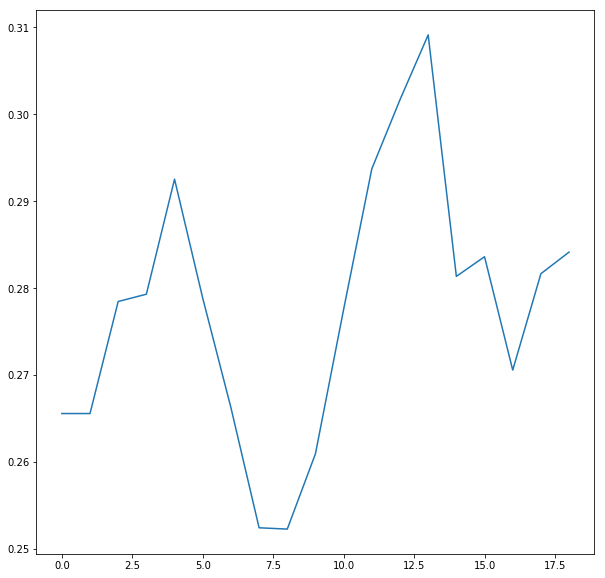

In [9]:
score = []
for k in range(1, 20):
    #print(k)
    classifier = KNeighborsClassifier(n_neighbors=k, weights = 'distance')
    classifier.fit(exp1.x_train, exp1.y_train)
    predicted = classifier.predict(exp1.x_test)
    #print(predicted)
    #print(exp1.y_test)
    score.append(metrics.precision_score(exp1.y_test, predicted, average='macro'))
plt.figure(figsize=(10,10))
plt.plot(score)
plt.show()

#### Histogram size

Histogram size has a big impact on performace. We found lower values to be much better.

[0.27844807869575666, 0.21310347780027414, 0.21834189632177248, 0.2476533874908488, 0.214730377694774, 0.21542109578874286, 0.19986560552737018, 0.18983211233211233]


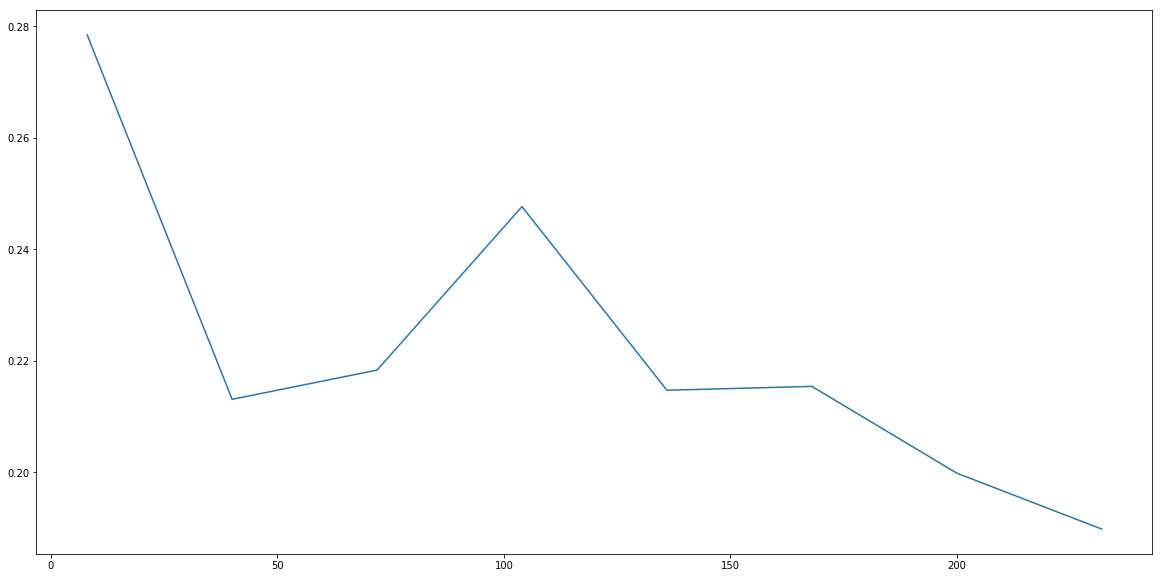

In [10]:
score = []
xrange = range(8, 264, 32)
for h in xrange:
    #print(h)
    fids30_data.resetFeatures()
    fids30_data.addFeatures(Histogram(h))
    exp = Experiment(fids30_data, KNeighborsClassifier(n_neighbors=3, weights = 'distance'),  "%d Histogram with Knn k=%d" % (h, 10))
    exp.train()
    score.append(exp.precision())
print(score)
plt.figure(figsize=(20,10))
plt.plot(xrange, score)
plt.show()

### Multi Layered Perceptron

We achived the best performace on histogram data using mlp classifier. For some fruits like grapefruits and pommegrapes the performace was about 50%. Overall 28%. 

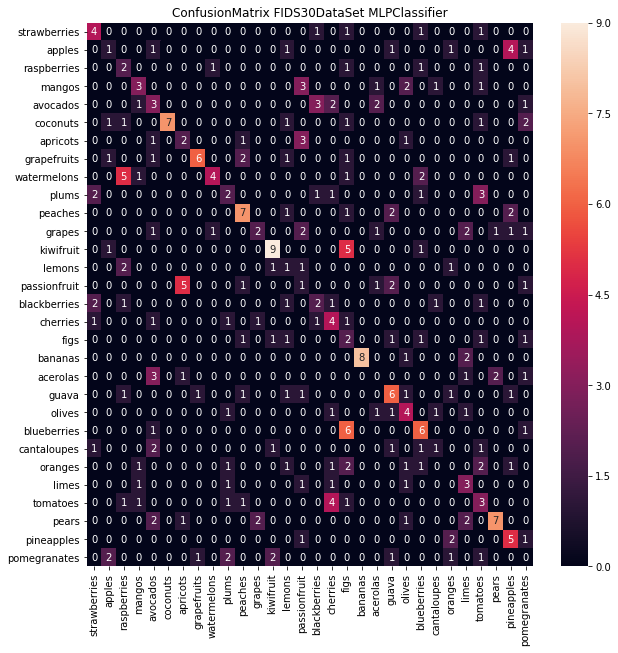

In [11]:

# mlp
exp1 = Experiment(fids30_data,  MLPClassifier(max_iter=3200, verbose=False))
exp1.train()
exp1.evaluate(figure=True)


In [12]:
exp1.evaluate(text=True)

classifier MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=3200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False):
              precision    recall  f1-score   support

           0       0.40      0.50      0.44         8
           1       0.17      0.10      0.12        10
           2       0.15      0.33      0.21         6
           3       0.38      0.27      0.32        11
           4       0.19      0.25      0.21        12
           5       1.00      0.50      0.67        14
           6       0.22      0.25      0.24         8
           7       0.75      0.46      0.57        13
   

### Visual Bag of Words

We repeat the experiments but instead of extracting histogram data from the images we extract Visual Descriptors. We then use this data to train different classifiers. As with traditional Histograms, BOV also counts the frequency of descriptors. As a parameter we can set the amount of descriptors we use to describe an image.

In [13]:
# prepare dataset with bov features
fids30_data.resetFeatures()
fids30_data.addFeatures(BOV(20))

/home/lazafi/labor/ml-2019/male2019/3/env/lib/python3.5/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


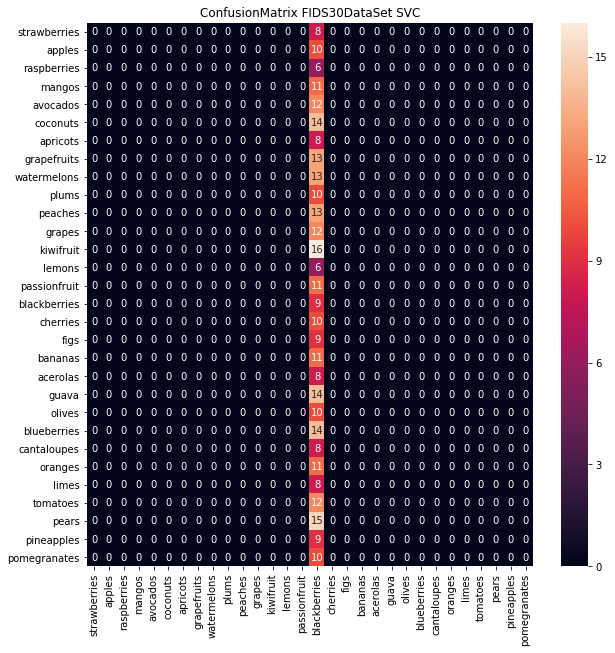

In [14]:

# svc
exp1 = Experiment(fids30_data,  svm.SVC())
exp1.train()
exp1.evaluate(figure=True)


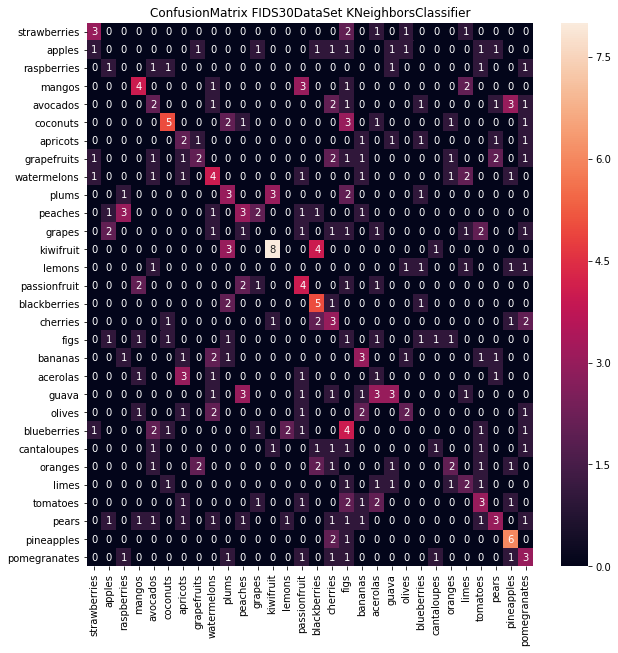

In [15]:

# knn
exp1 = Experiment(fids30_data, KNeighborsClassifier(n_neighbors=3, weights = 'distance'))
exp1.train()
exp1.evaluate(figure=True)


/home/lazafi/labor/ml-2019/male2019/3/env/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


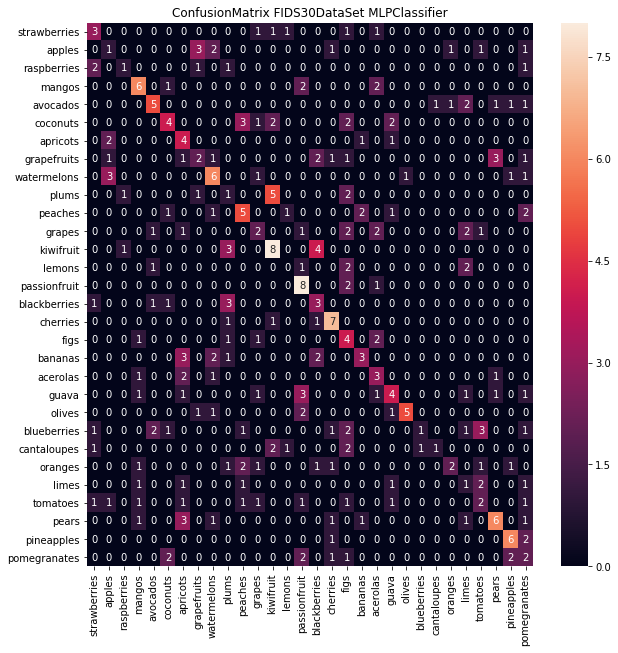

classifier MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=3200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False):
              precision    recall  f1-score   support

           0       0.33      0.38      0.35         8
           1       0.12      0.10      0.11        10
           2       0.33      0.17      0.22         6
           3       0.46      0.55      0.50        11
           4       0.50      0.42      0.45        12
           5       0.40      0.29      0.33        14
           6       0.24      0.50      0.32         8
           7       0.25      0.15      0.19        13
   

In [16]:

# mlp
exp1 = Experiment(fids30_data, MLPClassifier(max_iter=3200, verbose=False))
exp1.train()
exp1.evaluate(figure=True, text=True)


### deep convolutional neural network


### Develop a Baseline CNN Model

In this section, we will develop a baseline Convolutional Neural Network model for the FIDS30 dataset.

A baseline model will establish a minimum model performance to which all of our other models can be compared, as well as a model architecture that we can use as the basis of study and improvement.

We will use for starting point the general architectural principles of the VGG models. These are a good starting point because they achieved top performance in the ILSVRC 2014 competition and because the modular structure of the architecture is easy to understand and implement. 

The architecture involves stacking convolutional layers with small 3×3 filters followed by a max pooling layer. Together, these layers form a block, and these blocks can be repeated where the number of filters in each block is increased with the depth of the network such as 32, 64, 128, 256 for the first four blocks of the model. Padding is used on the convolutional layers to ensure the height and width shapes of the output feature maps matches the inputs.

We can create a function named define_model() that will define a model and return it ready to be fit on the dataset. This function can then be customized to define different baseline models, e.g. versions of the model with 1, 2, or 3 VGG style blocks.

The model will be fit with Stochastic Gradient Descent and we will start with a conservative learning rate of 0.001 and a momentum of 0.9.

### Four Block VGG Model


In [ ]:
from datetime import datetime

# baseline model for the dataset
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

from src.fruits.helper import *

start = datetime.now()
print('Start time: ', start)

# define cnn model
def define_model_4_block():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(30, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['acc'], color='blue', label='train')
    pyplot.plot(history.history['val_acc'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.show()
    #pyplot.savefig(filename + '_plot.png')
    pyplot.close()

# run the test harness for evaluating a model
def run_test_4_block():
    # define model
    model = define_model_4_block()
    # create data generator
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterators
    fruit_data = FIDS30DataSet(path="/home/lazafi/labor/ml-2019/male2019/3/data/FIDS30", images=False)
    (df_train, df_test) = fruit_data.getDataFrames(ratio=0.3)

    train_it = datagen.flow_from_dataframe(df_train, batch_size=64, target_size=(224, 224))
    test_it = datagen.flow_from_dataframe(df_test, batch_size=64, target_size=(224, 224))
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
    # evaluate model
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    print('Plots...')
    summarize_diagnostics(history)
    model.save('model_4_block.h5')
    
# entry point, run the test harness
run_test_4_block()

stop = datetime.now()
print('Stop time: ', stop)
print('Training time: ', stop - start)

Start time:  2019-08-07 21:18:09.708328


W0807 21:18:10.052962 140716743952128 deprecation.py:323] From /home/lazafi/labor/ml-2019/male2019/3/env/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 56, 56, 128)       73856     
__________

W0807 21:18:10.301024 140716743952128 deprecation_wrapper.py:119] From /home/lazafi/labor/ml-2019/male2019/3/env/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



### Image Data Augmentation

Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.

Training deep learning neural network models on more data can result in more skillful models, and the augmentation techniques can create variations of the images that can improve the ability of the fit models to generalize what they have learned to new images.

Data augmentation can also act as a regularization technique, adding noise to the training data, and encouraging the model to learn the same features, invariant to their position in the input.

Small changes to the input photos might be useful for this problem, such as small shifts and horizontal flips. These augmentations can be specified as arguments to the ImageDataGenerator used for the training dataset. The augmentations should not be used for the test dataset, as we wish to evaluate the performance of the model on the unmodified photographs.

This requires that we have a separate ImageDataGenerator instance for the train and test dataset, then iterators for the train and test sets created from the respective data generators.

This approach is expected to slow the rate of improvement during training and hopefully counter the overfitting of the training dataset. As such, we will increase the number of training epochs from 20 to 50 to give the model more space for refinement.

In [ ]:
from datetime import datetime
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

start = datetime.now()
print('Start time: ', start)

# define cnn model
def define_model_data_augmentation():
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(30, activation='softmax'))
    
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['acc'], color='blue', label='train')
    pyplot.plot(history.history['val_acc'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig(filename + '_plot.png')
    pyplot.close()

# run the test harness for evaluating a model
def run_test_data_augmentation():
    # define model
    model = define_model_data_augmentation()
    # create data generator
    train_datagen = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterator
     # prepare iterators
    fruit_data = FIDS30DataSet(path="/home/lazafi/labor/ml-2019/male2019/3/data/FIDS30", images=False)
    (df_train, df_test) = fruit_data.getDataFrames(ratio=0.3)

    train_it = datagen.flow_from_dataframe(df_train, batch_size=64, target_size=(224, 224))
    test_it = datagen.flow_from_dataframe(df_test, batch_size=64, target_size=(224, 224))
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
    # evaluate model
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)
    model.save('model_data_augmentation.h5')

# entry point, run the test harness
run_test_data_augmentation()

stop = datetime.now()
print('Stop time: ', stop)
print('Training time: ', stop - start)

### Discussion

We have explored two different models with a VGG-based architecture.

The results can be summarized below, although we must assume some variance in these results given the stochastic nature of the algorithm:

    VGG 1: 27.933 %
    VGG 4: 39.665 %
    
With one different improvements to the baseline model:

    Baseline VGG4 + Data Augmentation: 53.073 %

As suspected, the addition of regularization techniques slows the progression of the learning algorithms and reduces overfitting, resulting in improved performance on the holdout dataset.

### Explore Transfer Learning

Transfer learning involves using all or parts of a model trained on a related task.

Keras provides a range of pre-trained models that can be loaded and used wholly or partially via the Keras Applications API.

A useful model for transfer learning is one of the VGG models, such as VGG-16 with 16 layers that at the time it was developed, achieved top results on the ImageNet photo classification challenge.

The model is comprised of two main parts, the feature extractor part of the model that is made up of VGG blocks, and the classifier part of the model that is made up of fully connected layers and the output layer.

We can use the feature extraction part of the model and add a new classifier part of the model that is tailored to the our dataset. Specifically, we can hold the weights of all of the convolutional layers fixed during training, and only train new fully connected layers that will learn to interpret the features extracted from the model and make a multiclass classification.

This can be achieved by loading the VGG-16 model, removing the fully connected layers from the output-end of the model, then adding the new fully connected layers to interpret the model output and make a prediction. The classifier part of the model can be removed automatically by setting the “include_top” argument to “False“, which also requires that the shape of the input also be specified for the model, in this case (224, 224, 3). This means that the loaded model ends at the last max pooling layer, after which we can manually add a flatten layer and the new clasifier layers.

We will generate our training data using the Keras ImageDataGenerator. 

The ImageDataGenerator will make an X_training data from a directory. The sub-directory in that directory will be used as a class for each object. The image will be loaded with the RGB color mode, with the categorical class mode for the Y_training data, with a batch size of 64. Finally, shuffle the data. 

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

train_path = new_dataset_path + 'train'
test_path = new_dataset_path + 'test'

# Defining the hyperparameters
batch_size = 64
image_size = 224
num_class = 30


train_datagen = ImageDataGenerator(validation_split=0.3,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
# prepare iterators
fruit_data = FIDS30DataSet(path="/home/lazafi/labor/ml-2019/male2019/3/data/FIDS30", images=False)
(df_train, df_test) = fruit_data.getDataFrames(ratio=0.3)

train_generator = train_datagen.flow_from_dataframe(df_train,
                                target_size=(image_size,image_size),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',
                                shuffle=True)

In [ ]:
x_batch, y_batch = train_generator.next()

fig=plt.figure()
columns = 5
rows = 5
for i in range(1, columns*rows):
    num = np.random.randint(batch_size)
    image = x_batch[num].astype(np.int)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image)
plt.show()

In [ ]:
After that let's create our network model from VGG16 with imageNet pre-trained weight. We will freeze these layers so that the layers are not trainable to help us reduce the computation time.

### Creating our Model from VGG16

As you can see below, the summary of our network model. From an input from VGG16 Layers, then we add 2 Fully Connected Layer which will extract 1024 features and an output layer that will compute the 8 classes with the softmax activation. 

In [ ]:
import keras
from keras.models import Model, load_model
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16


#Load the VGG model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

print(base_model.summary())

    # Freeze the layers 
for layer in base_model.layers:
    layer.trainable = False
 
# # Create the model
model = keras.models.Sequential()

# # Add the vgg convolutional base model
model.add(base_model)
 
# # Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(num_class, activation='softmax'))
 
# # Show a summary of the model. Check the number of trainable parameters    
print(model.summary())

### Training

In [ ]:
# # Compile the model
from keras.optimizers import SGD

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=1e-3),
              metrics=['accuracy'])

# # Start the training process
# model.fit(x_train, y_train, validation_split=0.30, batch_size=32, epochs=50, verbose=2)

history = model.fit_generator(
                train_generator,
                steps_per_epoch = train_generator.n/batch_size,
                epochs=10)
        
model.save('fruits_VGG16.h5')

# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')
plt.show()

As you can see, our losses are dropped significantly and the accuracy is almost 88%.

Here's how to get the confusion matrix(or maybe statistics using scikit-learn) for all classes:

1.Predict classes

In [ ]:
import numpy

model = load_model('fruits_VGG16.h5')

#test_generator = ImageDataGenerator()

#test_data_generator = test_generator.flow_from_directory(
                directory = test_path, # Put your path here
                target_size = (image_size, image_size),
                batch_size=32,
                shuffle=False)

test_steps_per_epoch = numpy.math.ceil(test_it.samples / test_it.batch_size)

predictions = model.predict_generator(test_it, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)

## Cars Data Set
   
The Cars Dataset contains Monochrome images. We classify these images wether there is a car in them or no car.   

In [2]:
# prepare the car dataset with histogram features
#datapath = "/home/lazafi/labor/ml-2019/male2019/3/data/CarData"
car_data = CarDataSet()
car_data.loadImages("/home/lazafi/labor/ml-2019/male2019/3/data/CarData/TrainImages")
car_data.loadImages("/home/lazafi/labor/ml-2019/male2019/3/data/CarData/TestImages", "neg")
print(car_data.count)


loaded neg:500 pos:551
loaded neg:670 pos:551
1221


### Histogram Data

Since the Images are monochrome, using histogram data is probably not as efficient as for the Fruits dataset.


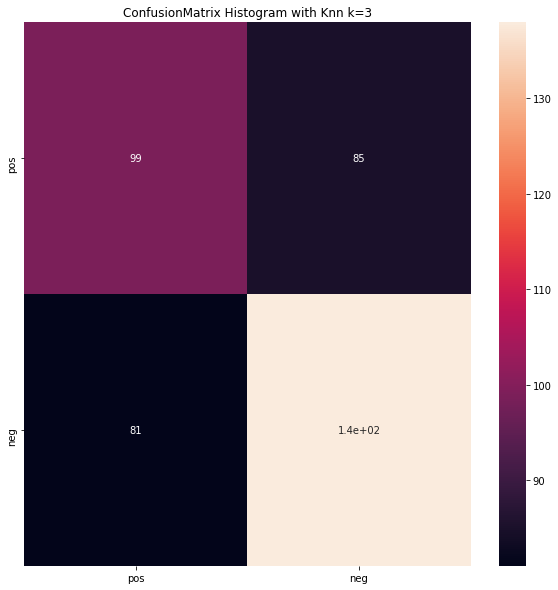

classifier KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='distance'):
              precision    recall  f1-score   support

           0       0.55      0.54      0.54       184
           1       0.62      0.63      0.62       219

    accuracy                           0.59       403
   macro avg       0.58      0.58      0.58       403
weighted avg       0.59      0.59      0.59       403




In [3]:
car_data.addFeatures(Histogram(10))

# knn
exp1 = Experiment(car_data, KNeighborsClassifier(n_neighbors=3, weights = 'distance'),  "Histogram with Knn k=3")
exp1.train()
exp1.evaluate(figure=True, text=True)


/home/lazafi/labor/ml-2019/male2019/3/env/lib/python3.5/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.57      0.57      0.57       184
           1       0.63      0.63      0.63       219

    accuracy                           0.60       403
   macro avg       0.60      0.60      0.60       403
weighted avg       0.60      0.60      0.60       403




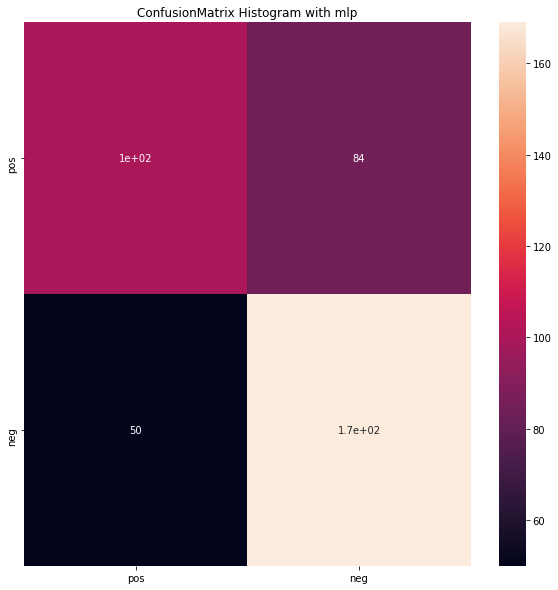

classifier MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=3200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False):
              precision    recall  f1-score   support

           0       0.67      0.54      0.60       184
           1       0.67      0.77      0.72       219

    accuracy                           0.67       403
   macro avg       0.67      0.66      0.66       403
weighted avg       0.67      0.67      0.66       403




In [4]:
# knn
exp1 = Experiment(car_data, svm.SVC(),  "Histogram with svm")
exp1.train()
exp1.evaluate(text=True)

exp1 = Experiment(car_data, MLPClassifier(max_iter=3200, verbose=False),  "Histogram with mlp")
exp1.train()
exp1.evaluate(text=True, figure=True)


As expected the performace of all classifiers is only slightly over the baseleine of 50%. Moreover, since the classes are unbalanced the classifiers are probably useles

### Visual Bag of Words

Using the VBOW approach we expect much better results. Using the MLPClassifier we achive ap 80% accuracy with only some  more "pos" images missclassified as "neg"

skipping img 929 size (40, 100)


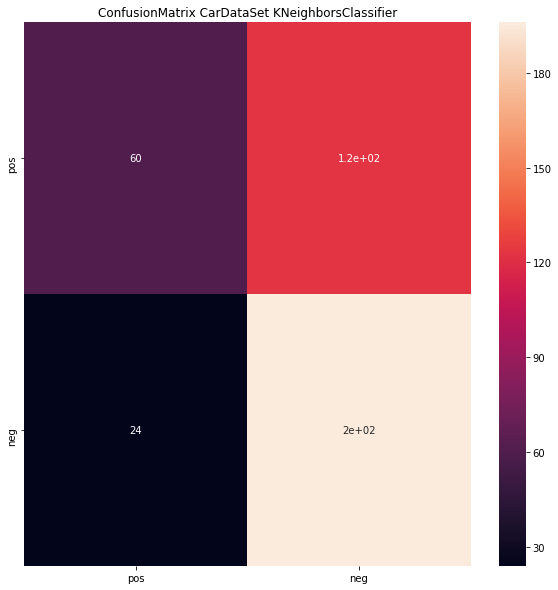

classifier KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='distance'):
              precision    recall  f1-score   support

           0       0.71      0.33      0.45       183
           1       0.61      0.89      0.73       220

    accuracy                           0.64       403
   macro avg       0.66      0.61      0.59       403
weighted avg       0.66      0.64      0.60       403




/home/lazafi/labor/ml-2019/male2019/3/env/lib/python3.5/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


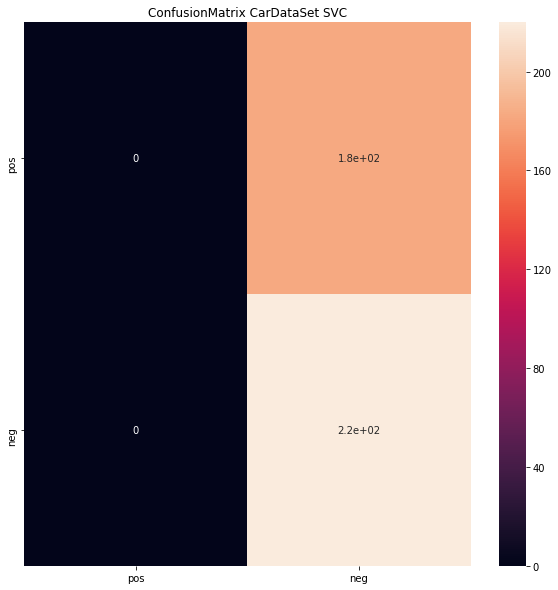

/home/lazafi/labor/ml-2019/male2019/3/env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       183
           1       0.55      1.00      0.71       220

    accuracy                           0.55       403
   macro avg       0.27      0.50      0.35       403
weighted avg       0.30      0.55      0.39       403




/home/lazafi/labor/ml-2019/male2019/3/env/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


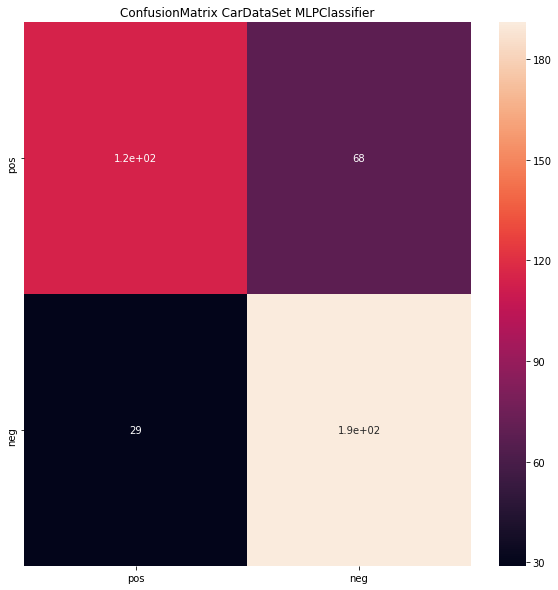

classifier MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False):
              precision    recall  f1-score   support

           0       0.80      0.63      0.70       183
           1       0.74      0.87      0.80       220

    accuracy                           0.76       403
   macro avg       0.77      0.75      0.75       403
weighted avg       0.77      0.76      0.75       403




In [5]:
car_data.resetFeatures()
car_data.addFeatures(BOV(30, debug=False))

# knn
exp1 = Experiment(car_data, KNeighborsClassifier(n_neighbors=3, weights = 'distance'))
exp1.train()
exp1.evaluate(figure=True, text=True)

# svm
exp1 = Experiment(car_data, svm.SVC())
exp1.train()
exp1.evaluate(figure=True, text=True)

# mlp
exp1 = Experiment(car_data, MLPClassifier())
exp1.train()
exp1.evaluate(figure=True, text=True)


#### size of the BOV Histogram

10
skipping img 929 size (40, 100)
20
skipping img 929 size (40, 100)
30
skipping img 929 size (40, 100)
40
skipping img 929 size (40, 100)
[0.6871372549019608, 0.7580206354909913, 0.8132451216252339, 0.8125]


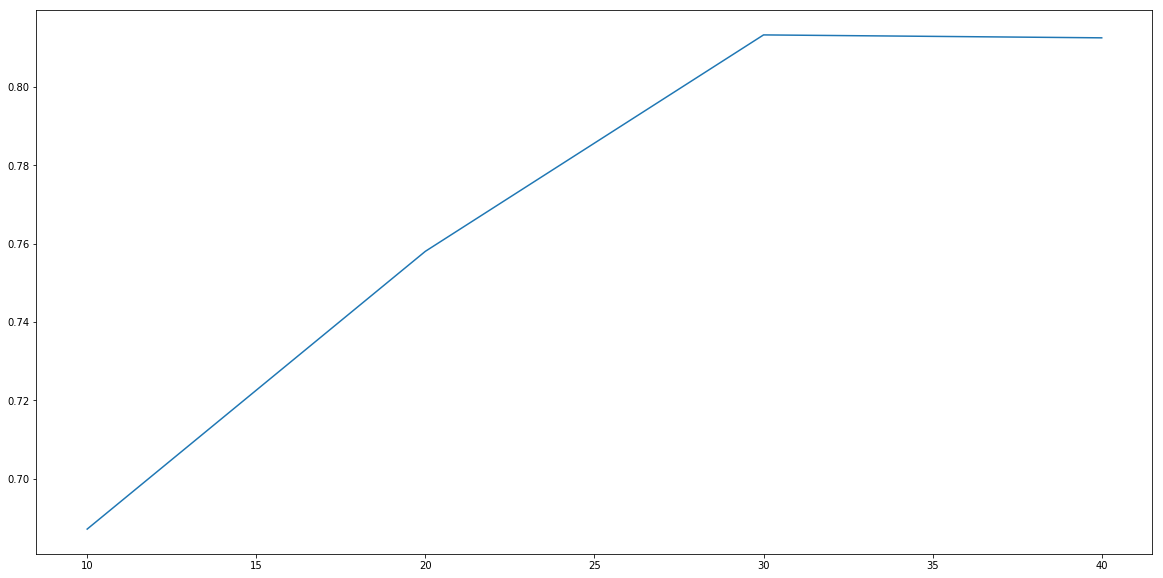

In [6]:
score = []
xrange = range(10, 50, 10)
for h in xrange:
    print(h)
    car_data.resetFeatures()
    car_data.addFeatures(BOV(h))
    exp = Experiment(car_data, MLPClassifier(max_iter=3200, verbose=False),  "BOV(%d)" % h)
    exp.train()
    score.append(exp.precision())
print(score)
plt.figure(figsize=(20,10))
plt.plot(xrange, score)
plt.show()

## CNN

For the CNN part of the exercise, please see the files CNN_Car_Keras_final.ipynb and CNN_fruits_Keras_final.ipynb included in our submission. These files contain information about our approach on CNN.
